## CNN十分类

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


In [ ]:
# 乱码处理脚本 仅初始化使用
base_dir = 'data/FruitAnimal'

name_map = {
    '动物': 'animal',
    '牛': 'cow',
    '狗': 'dog',
    '猪': 'pig',
    '猫': 'cat',
    '马': 'horse',
    '水果': 'fruit',
    '榴莲': 'durian',
    '橙子': 'orange',
    '苹果': 'apple',
    '葡萄': 'grape',
    '香蕉': 'banana'
}

for dir_name in os.listdir(base_dir):
    full_path = os.path.join(base_dir, dir_name)
    if os.path.isdir(full_path) and dir_name in name_map:
        new_name = name_map[dir_name]
        new_path = os.path.join(base_dir, new_name)
        os.rename(full_path, new_path)
        print(f'Renamed {full_path} to {new_path}')

for category_dir in ['animal', 'fruit']:
    cat_path = os.path.join(base_dir, category_dir)
    for sub_dir in os.listdir(cat_path):
        sub_full_path = os.path.join(cat_path, sub_dir)
        if os.path.isdir(sub_full_path) and sub_dir in name_map:
            new_sub_name = name_map[sub_dir]
            new_sub_path = os.path.join(cat_path, new_sub_name)
            os.rename(sub_full_path, new_sub_path)
            print(f'Renamed {sub_full_path} to {new_sub_path}')


In [ ]:
import os
import shutil
import random

base_dir = 'data/fruitAnimal'
animal_dir = os.path.join(base_dir, 'animal')
fruit_dir = os.path.join(base_dir, 'fruit')

train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')

os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

train_animal_dir = os.path.join(train_dir, 'animal')
train_fruit_dir = os.path.join(train_dir, 'fruit')
val_animal_dir = os.path.join(val_dir, 'animal')
val_fruit_dir = os.path.join(val_dir, 'fruit')

os.makedirs(train_animal_dir, exist_ok=True)
os.makedirs(train_fruit_dir, exist_ok=True)
os.makedirs(val_animal_dir, exist_ok=True)
os.makedirs(val_fruit_dir, exist_ok=True)

categories = [
    (animal_dir, train_animal_dir, val_animal_dir),
    (fruit_dir, train_fruit_dir, val_fruit_dir)
]

train_ratio = 0.8

for src_category_dir, dst_train_category_dir, dst_val_category_dir in categories:
    for class_name in os.listdir(src_category_dir):
        class_dir = os.path.join(src_category_dir, class_name)
        if os.path.isdir(class_dir):
            images = [f for f in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, f))]
            random.shuffle(images)

            train_count = int(len(images) * train_ratio)
            train_images = images[:train_count]
            val_images = images[train_count:]

            train_class_dir = os.path.join(dst_train_category_dir, class_name)
            val_class_dir = os.path.join(dst_val_category_dir, class_name)
            os.makedirs(train_class_dir, exist_ok=True)
            os.makedirs(val_class_dir, exist_ok=True)

            for img in train_images:
                src = os.path.join(class_dir, img)
                dst = os.path.join(train_class_dir, img)
                shutil.move(src, dst)

            for img in val_images:
                src = os.path.join(class_dir, img)
                dst = os.path.join(val_class_dir, img)
                shutil.move(src, dst)

            os.rmdir(class_dir)

if not os.listdir(animal_dir):
    os.rmdir(animal_dir)
if not os.listdir(fruit_dir):
    os.rmdir(fruit_dir)


In [ ]:
base_dir = 'data/FruitAnimal'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')

train_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
val_dataset = datasets.ImageFolder(val_dir, transform=val_transforms)
# print(train_dataset.classes)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

In [3]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * (224//8) * (224//8), 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN(num_classes=10).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train_one_epoch(model, optimizer, criterion, dataloader, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    return running_loss / total, correct / total

def evaluate(model, criterion, dataloader, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return running_loss / total, correct / total


Epoch [1/30]: Train Loss: 2.2265, Train Acc: 0.1343, Val Loss: 1.9741, Val Acc: 0.2162
Epoch [2/30]: Train Loss: 1.8960, Train Acc: 0.2784, Val Loss: 1.7544, Val Acc: 0.2757
Epoch [3/30]: Train Loss: 1.7219, Train Acc: 0.3186, Val Loss: 1.5632, Val Acc: 0.4541
Epoch [4/30]: Train Loss: 1.6089, Train Acc: 0.3684, Val Loss: 1.4933, Val Acc: 0.4757
Epoch [5/30]: Train Loss: 1.5377, Train Acc: 0.4114, Val Loss: 1.3960, Val Acc: 0.4703
Epoch [6/30]: Train Loss: 1.4456, Train Acc: 0.4515, Val Loss: 1.3636, Val Acc: 0.4486
Epoch [7/30]: Train Loss: 1.3429, Train Acc: 0.4889, Val Loss: 1.2012, Val Acc: 0.5189
Epoch [8/30]: Train Loss: 1.2166, Train Acc: 0.5416, Val Loss: 1.3062, Val Acc: 0.5135
Epoch [9/30]: Train Loss: 1.2050, Train Acc: 0.5416, Val Loss: 1.1833, Val Acc: 0.5946
Epoch [10/30]: Train Loss: 1.1226, Train Acc: 0.5609, Val Loss: 1.1046, Val Acc: 0.5892
Epoch [11/30]: Train Loss: 1.0653, Train Acc: 0.6080, Val Loss: 1.1007, Val Acc: 0.5622
Epoch [12/30]: Train Loss: 1.0766, Train 

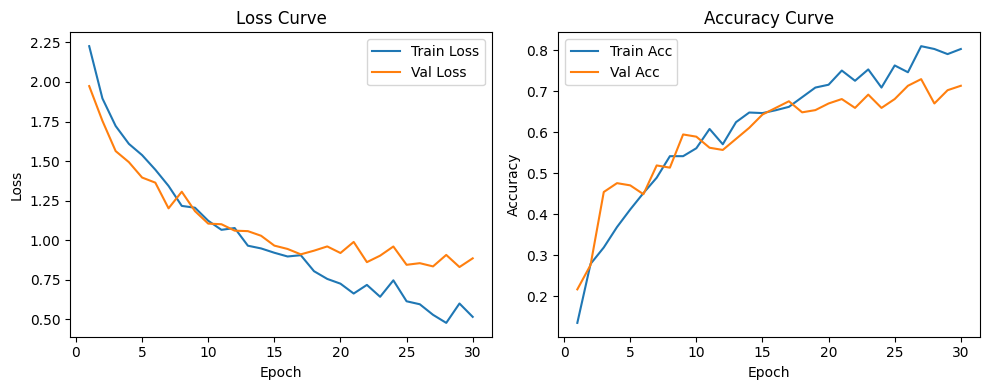

In [ ]:
import matplotlib.pyplot as plt

epochs = 30
best_acc = 0.0

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(epochs):
    train_loss, train_acc = train_one_epoch(model, optimizer, criterion, train_loader, device)
    val_loss, val_acc = evaluate(model, criterion, val_loader, device)
    
    # 保存数据
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), "best_model.pth") # 保存最优模型
        
    print(f"Epoch [{epoch+1}/{epochs}]: "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

print("Best Validation Accuracy:", best_acc)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), val_losses, label='Val Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(range(1, epochs+1), train_accuracies, label='Train Acc')
plt.plot(range(1, epochs+1), val_accuracies, label='Val Acc')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()



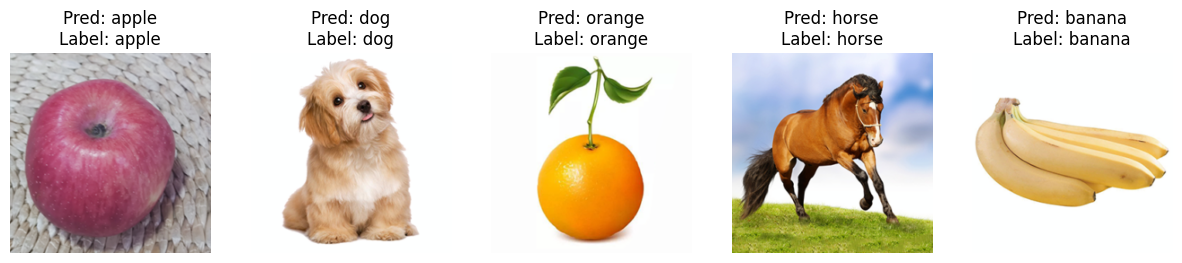

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt

model.eval()
class_names = val_dataset.classes  # 获取类别名称列表

random_indices = random.sample(range(len(val_dataset)), 5)

images_list = []
labels_list = []
for idx in random_indices:
    img, lbl = val_dataset[idx]
    images_list.append(img)
    labels_list.append(lbl)

images_tensor = torch.stack(images_list).to(device)
labels_tensor = torch.tensor(labels_list).to(device)

with torch.no_grad():
    outputs = model(images_tensor)
    _, preds = torch.max(outputs, 1)

images_cpu = images_tensor.cpu().numpy()
labels_cpu = labels_tensor.cpu().numpy()
preds_cpu = preds.cpu().numpy()

fig, axes = plt.subplots(1, 5, figsize=(15,3))
for i in range(5):
    img = images_cpu[i].transpose((1,2,0))  # C,H,W -> H,W,C
    img = img * np.array([0.229,0.224,0.225]) + np.array([0.485,0.456,0.406])
    img = np.clip(img,0,1)
    axes[i].imshow(img)
    axes[i].set_title(f"Pred: {class_names[preds_cpu[i]]}\nLabel: {class_names[labels_cpu[i]]}")
    axes[i].axis('off')

plt.show()


### 不同网络结构、参数数量对精度的影响

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# 小型CNN
class SmallCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SmallCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3,16,3,padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16,32,3,padding=1), nn.ReLU(),
            nn.MaxPool2d(2)
        )
        # 假设输入224x224，两次maxpool后特征图为(32通道,56x56)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32*56*56, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# 中等CNN（VGG-like）
class MediumCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(MediumCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3,32,3,padding=1), nn.ReLU(),
            nn.Conv2d(32,32,3,padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            
            nn.Conv2d(32,64,3,padding=1), nn.ReLU(),
            nn.Conv2d(64,64,3,padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            
            nn.Conv2d(64,128,3,padding=1), nn.ReLU(),
            nn.Conv2d(128,128,3,padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128*28*28,256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256,num_classes)
        )
    def forward(self,x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# 大型CNN（使用ResNet18）
def LargeCNN(num_classes=10):
    model = models.resnet18(pretrained=False)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model


In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

models_to_compare = {
    "SmallCNN": SmallCNN(num_classes=10),
    "MediumCNN": MediumCNN(num_classes=10),
    "ResNet18": LargeCNN(num_classes=10)
}

results = {}
epochs = 10 
for name, net in models_to_compare.items():
    net = net.to(device)
    optimizer = optim.Adam(net.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    best_acc = 0.0
    for epoch in range(epochs):
        train_loss, train_acc = train_one_epoch(net, optimizer, criterion, train_loader, device)
        val_loss, val_acc = evaluate(net, criterion, val_loader, device)
        if val_acc > best_acc:
            best_acc = val_acc
        print(f"{name} Epoch [{epoch+1}/{epochs}]: Val Acc: {val_acc:.4f}")

    # 统计参数数量
    params_count = sum(p.numel() for p in net.parameters())
    results[name] = {"best_acc": best_acc, "params": params_count}

print("Comparison Results:")
for k,v in results.items():
    print(f"{k}: Params={v['params']}, Best Val Acc={v['best_acc']:.4f}")


c:\Users\scpsyl\.conda\envs\pytorch\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\scpsyl\.conda\envs\pytorch\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


SmallCNN Epoch [1/10]: Val Acc: 0.3568
SmallCNN Epoch [2/10]: Val Acc: 0.5081
SmallCNN Epoch [3/10]: Val Acc: 0.5946
SmallCNN Epoch [4/10]: Val Acc: 0.6324
SmallCNN Epoch [5/10]: Val Acc: 0.6865
SmallCNN Epoch [6/10]: Val Acc: 0.6757
SmallCNN Epoch [7/10]: Val Acc: 0.6919
SmallCNN Epoch [8/10]: Val Acc: 0.7297
SmallCNN Epoch [9/10]: Val Acc: 0.7514
SmallCNN Epoch [10/10]: Val Acc: 0.7243
MediumCNN Epoch [1/10]: Val Acc: 0.2054
MediumCNN Epoch [2/10]: Val Acc: 0.3405
MediumCNN Epoch [3/10]: Val Acc: 0.3568
MediumCNN Epoch [4/10]: Val Acc: 0.4919
MediumCNN Epoch [5/10]: Val Acc: 0.5405
MediumCNN Epoch [6/10]: Val Acc: 0.5243
MediumCNN Epoch [7/10]: Val Acc: 0.5189
MediumCNN Epoch [8/10]: Val Acc: 0.5568
MediumCNN Epoch [9/10]: Val Acc: 0.5892
MediumCNN Epoch [10/10]: Val Acc: 0.6216
ResNet18 Epoch [1/10]: Val Acc: 0.2703
ResNet18 Epoch [2/10]: Val Acc: 0.3081
ResNet18 Epoch [3/10]: Val Acc: 0.4595
ResNet18 Epoch [4/10]: Val Acc: 0.4757
ResNet18 Epoch [5/10]: Val Acc: 0.5514
ResNet18 Epoc

### 训练超参数与数据增强对精度的影响

#### 不同学习率

In [17]:
learning_rates = [0.1, 0.01, 0.001, 0.0001]
lr_results = {}
for lr in learning_rates:
    model = MediumCNN(num_classes=10).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    best_acc = 0.0
    for epoch in range(5):
        train_loss, train_acc = train_one_epoch(model, optimizer, criterion, train_loader, device)
        val_loss, val_acc = evaluate(model, criterion, val_loader, device)
        if val_acc > best_acc:
            best_acc = val_acc
    lr_results[lr] = best_acc

print("Learning Rate Comparison:")
for lr, acc in lr_results.items():
    print(f"LR={lr}, Best Val Acc={acc:.4f}")


Learning Rate Comparison:
LR=0.1, Best Val Acc=0.1135
LR=0.01, Best Val Acc=0.1081
LR=0.001, Best Val Acc=0.5405
LR=0.0001, Best Val Acc=0.5568


#### 不同数据增强策略

In [18]:
from torchvision import transforms

no_aug_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

basic_aug_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

strong_aug_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomResizedCrop(224, scale=(0.8,1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

aug_strategies = {
    "no_aug": no_aug_transforms,
    "basic_aug": basic_aug_transforms,
    "strong_aug": strong_aug_transforms
}

aug_results = {}
for aug_name, aug_trans in aug_strategies.items():
    # 重新加载数据集
    train_dataset.transform = aug_trans
    val_dataset.transform = no_aug_transforms # val集一般不增强，只做归一化
    train_loader.dataset = train_dataset
    val_loader.dataset = val_dataset
    
    model = MediumCNN(num_classes=10).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    best_acc = 0.0
    for epoch in range(5):
        train_loss, train_acc = train_one_epoch(model, optimizer, criterion, train_loader, device)
        val_loss, val_acc = evaluate(model, criterion, val_loader, device)
        if val_acc > best_acc:
            best_acc = val_acc
    aug_results[aug_name] = best_acc

print("Data Augmentation Comparison:")
for aug_name, acc in aug_results.items():
    print(f"{aug_name}: Best Val Acc={acc:.4f}")


ValueError: dataset attribute should not be set after DataLoader is initialized

### 模型探索

In [14]:
class SmallerMediumCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SmallerMediumCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3,16,3,padding=1), nn.ReLU(),
            nn.Conv2d(16,16,3,padding=1), nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(16,32,3,padding=1), nn.ReLU(),
            nn.Conv2d(32,32,3,padding=1), nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32,64,3,padding=1), nn.ReLU(),
            nn.Conv2d(64,64,3,padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*28*28,128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128,num_classes)
        )
    def forward(self,x):
        x = self.features(x)
        x = self.classifier(x)
        return x


In [15]:
from torchvision.models import mobilenet_v2
def MobileNet(num_classes=10):
    model = mobilenet_v2(pretrained=False)
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    return model


In [16]:
candidate_models = {
    "OriginalMediumCNN": MediumCNN(num_classes=10),
    "SmallerMediumCNN": SmallerMediumCNN(num_classes=10),
    "MobileNetV2": MobileNet(num_classes=10)
}

light_results = {}
for name, net in candidate_models.items():
    net = net.to(device)
    optimizer = optim.Adam(net.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    best_acc = 0.0
    for epoch in range(10): # 多跑几轮看看稳定精度
        train_loss, train_acc = train_one_epoch(net, optimizer, criterion, train_loader, device)
        val_loss, val_acc = evaluate(net, criterion, val_loader, device)
        if val_acc > best_acc:
            best_acc = val_acc
    params_count = sum(p.numel() for p in net.parameters())
    light_results[name] = {"best_acc": best_acc, "params": params_count}

print("Lightweight Models Comparison:")
for k,v in light_results.items():
    print(f"{k}: Params={v['params']}, Best Val Acc={v['best_acc']:.4f}")


c:\Users\scpsyl\.conda\envs\pytorch\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\scpsyl\.conda\envs\pytorch\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Lightweight Models Comparison:
OriginalMediumCNN: Params=25979946, Best Val Acc=0.6216
SmallerMediumCNN: Params=6496026, Best Val Acc=0.5622
MobileNetV2: Params=2236682, Best Val Acc=0.5838
